# Imports

In [2]:
from skimage.segmentation import watershed, felzenszwalb
from skimage.filters import sobel
import pandas as pd
from pathlib import Path
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.filters import rank
from scipy import ndimage as ndi
from skimage.morphology import disk
import sklearn.metrics

# Setup

First, you need to access the data from this colab.

A way to do this is to add the following shared drive to your google drive:
https://drive.google.com/drive/folders/1AfBKbAmrMTLLH33441c5RSlwLp3ePhVT?usp=share_link


In order to do this, just rick-click on the drive and click "Add a shortcut to my Drive"

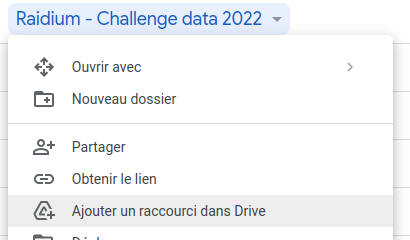

# Handling the data

In [3]:
# Load the train labels
# Note the transpose!
data_dir = Path("")
labels_train = pd.read_csv(data_dir  / "Y_train.csv", index_col=0).T

In [4]:
# Here is a function to load the data
def load_dataset(dataset_dir):
    dataset_list = []
    # Note: It's very important to load the images in the correct numerical order!
    # print(
    for image_file in list(sorted(Path(dataset_dir).glob("*.png"), key=lambda filename: int(filename.name.rstrip(".png")))):
        print(image_file)
        dataset_list.append(cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE))
    return np.stack(dataset_list, axis=0)

In [5]:
# Load the train and test sets
# If you've put the shortcut directly in your drive, this should work out of the box
# Else, edit the path
data_dir = Path("")
data_train = load_dataset(data_dir / "X_train")
data_test = load_dataset(data_dir / "X_test")

X_train/0.png
X_train/1.png
X_train/2.png
X_train/3.png
X_train/4.png
X_train/5.png
X_train/6.png
X_train/7.png
X_train/8.png
X_train/9.png
X_train/10.png
X_train/11.png
X_train/12.png
X_train/13.png
X_train/14.png
X_train/15.png
X_train/16.png
X_train/17.png
X_train/18.png
X_train/19.png
X_train/20.png
X_train/21.png
X_train/22.png
X_train/23.png
X_train/24.png
X_train/25.png
X_train/26.png
X_train/27.png
X_train/28.png
X_train/29.png
X_train/30.png
X_train/31.png
X_train/32.png
X_train/33.png
X_train/34.png
X_train/35.png
X_train/36.png
X_train/37.png
X_train/38.png
X_train/39.png
X_train/40.png
X_train/41.png
X_train/42.png
X_train/43.png
X_train/44.png
X_train/45.png
X_train/46.png
X_train/47.png
X_train/48.png
X_train/49.png
X_train/50.png
X_train/51.png
X_train/52.png
X_train/53.png
X_train/54.png
X_train/55.png
X_train/56.png
X_train/57.png
X_train/58.png
X_train/59.png
X_train/60.png
X_train/61.png
X_train/62.png
X_train/63.png
X_train/64.png
X_train/65.png
X_train/66.png
X_tra

In [6]:
# The train data is a numpy array of 1000 images of 512*512
print(f"X_train shape: {data_train.shape}")
# The train label is a dataframe of 1000 rows with 262144 (=512x512) columns
print(f"Y_train shape: {labels_train.shape}")

X_train shape: (2000, 512, 512)
Y_train shape: (2000, 262144)


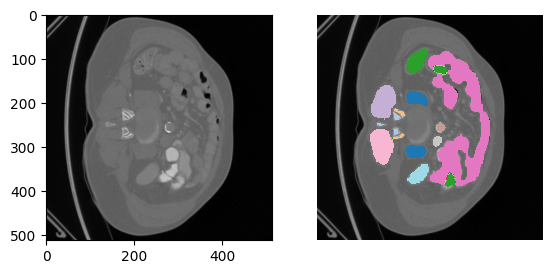

In [9]:
# Let's display some data
# Here is a function to display side by side a slide and a segmented mask
def plot_slice_seg(slice_image, seg):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(slice_image, cmap="gray")
    plt.axis("off")
    axes[1].imshow(slice_image, cmap="gray")
    seg_masked = np.ma.masked_where(seg.reshape((512,512)) == 0, (seg.reshape((512,512))))
    axes[1].imshow(seg_masked, cmap="tab20")
    plt.axis("off")

# Let's try it on a slide and ites segmentation mask
# Note: we have to reshape the rows of the dataframe into a 512*512 matrix
plot_slice_seg(data_train[0], labels_train.iloc[0].values.reshape((512,512)))

# Let's understand the data

Text(0, 0.5, 'Number of images')

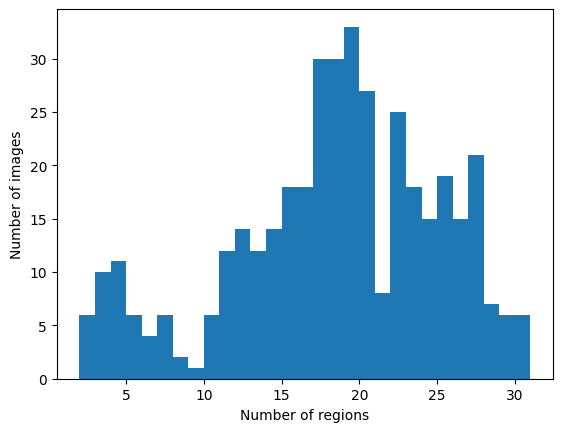

In [21]:
number_of_areas = [len(np.unique(labels_train.iloc[i])) for i in range(400)]
# print(np.mean(number_of_areas[:400]))
# print(np.std(number_of_areas[:400]))
plt.hist(number_of_areas[:400], bins=max(number_of_areas)-min(number_of_areas))
plt.xlabel("Number of regions")
plt.ylabel("Number of images")

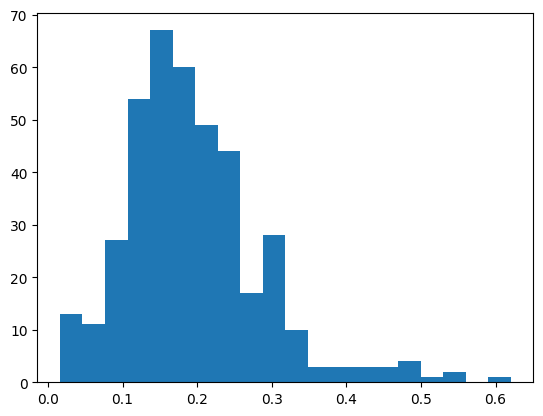

0.19383779525756836
0
nan


/tmp/ipykernel_4059527/3758996402.py:23: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


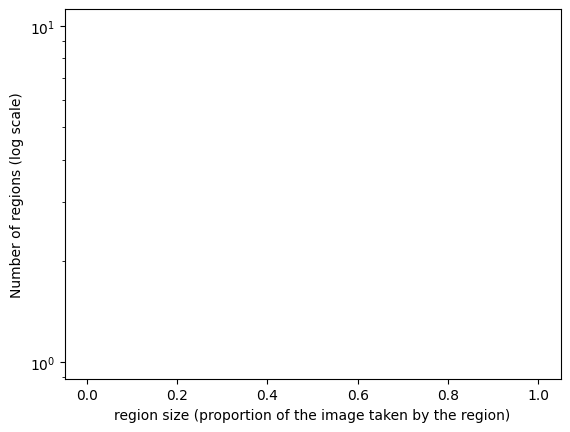

In [60]:
area_size = []
total_size = []
for i in range(400):
    total_size.append(np.sum(labels_train.iloc[i].values!=0))
    # for area in np.unique(labels_train.iloc[i].values)[1:]:
    #     # print(labels_train.iloc[i].values)
    #     # print(area)
    #     area_size.append(np.sum(labels_train.iloc[i].values==area))

# i = 0
# area = 1
# print(np.unique((labels_train.iloc[i].values)))
# plt.imshow((labels_train.iloc[i].values).reshape((512, 512)))
# print(area_size)
# print(total_size)
plt.hist(np.array(total_size)/512**2, bins=20)
plt.show()
print(np.mean(np.array(total_size)/512**2))
print(np.sum(np.array(area_size)/512**2>0.1))
print(np.mean(np.array(area_size)/512**2))
plt.hist(np.array(area_size)/512**2, bins=100)
# plt.xscale('log')
plt.yscale('log')
plt.xlabel("region size (proportion of the image taken by the region)")
plt.ylabel("Number of regions (log scale)")
plt.show()

# Let's compute a baseline

In [61]:
# Let's take a very basic watershed baseline
def compute_baseline_one_sample(data_slice):
    edges = sobel(data_slice)
    denoised = rank.median(data_slice, disk(2))
    markers = rank.gradient(denoised, disk(5)) < 20
    markers = ndi.label(markers)[0]
    label_predicted = watershed(edges, markers=markers, compactness=0.0001)
    return label_predicted

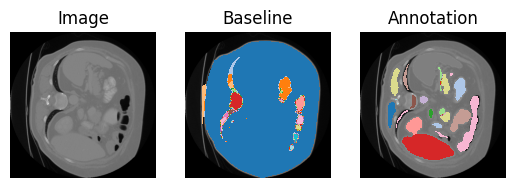

In [79]:
# Let's display the results
# Not too bad!
def plot_slice_seg(slice_image, seg, seg2):
    fig, axes = plt.subplots(1, 3)
    axes[0].imshow(slice_image, cmap="gray")
    axes[0].title.set_text('Image')
    axes[0].axis("off")
    axes[1].title.set_text('Baseline')
    axes[1].imshow(slice_image, cmap="gray")
    seg_masked = np.ma.masked_where(seg2.reshape((512,512)) == 1, (seg2.reshape((512,512))))
    axes[1].imshow(seg_masked, cmap="tab20")
    axes[1].axis("off")
    axes[2].title.set_text('Annotation')
    axes[2].imshow(slice_image, cmap="gray")
    seg_masked = np.ma.masked_where(seg.reshape((512,512)) == 0, (seg.reshape((512,512))))
    axes[2].imshow(seg_masked, cmap="tab20")
    axes[2].axis("off")
    
baseline = compute_baseline_one_sample(data_train[2])
# print(baseline)
# print(np.unique(baseline))
# print(np.argmax(np.unique(baseline))
plot_slice_seg(data_train[2], labels_train.iloc[2].values.reshape((512,512)), baseline)
# plot_slice_seg(data_train[2], compute_baseline_one_sample(data_train[2]))

## Let's measure its performances

In [63]:
# Compute the baseline on a whole dataset
def compute_baseline(dataset: np.array):
    labels_predicted_list = []
    for data_index in tqdm(range(len(dataset))):
        data_slice = dataset[data_index]
        label_predicted = compute_baseline_one_sample(data_slice)
        labels_predicted_list.append(label_predicted)
    return pd.DataFrame(np.stack(labels_predicted_list, axis=0).reshape((len(labels_predicted_list), -1)))

In [64]:
# Let's create a validation set first: the 200 first images of the train set
data_val = data_train[:200]
labels_val = labels_train.iloc[:200]

In [65]:
# Compute baseline on a few train data
# labels_val_predicted_baseline = compute_baseline(data_val)
import os
for i in range(len(data_train)):
    masks = compute_baseline(data_train[i:i+1]).values
    np.save(os.path.join("baseline_masks", str(i)+".npy"), masks.reshape(512, 512))

  0%|                                                     | 0/1 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
def rand_index_dataset(y_true_df: pd.DataFrame, y_pred_df: pd.DataFrame) -> float:
    """Compute the individual rand index for each sample in the dataset and then average it"""
    individual_rand_index = []
    for row_index in range(y_true_df.values.shape[0]):
        labels = y_true_df.values[row_index]
        preds = y_pred_df.values[row_index]
        individual_rand_index.append(sklearn.metrics.adjusted_rand_score(labels, preds))
    return np.mean(individual_rand_index)

In [ ]:
# Compute the metric on the validation set
rand_index_dataset(labels_val, labels_val_predicted_baseline)
# We get => 0.14 (0.1369409193608601); Not so bad, but room for improvements!
# Let's see if you can do better!